In [18]:
import pandas as pd

In [19]:
from src.plots import draw_plots, draw_plots_grid

In [20]:
df = pd.read_csv("./cleaned_data/14thJune2025_p07.csv", )
df.set_index("dateTime", inplace = True)
df.drop("participant_id", axis = 1, inplace = True)

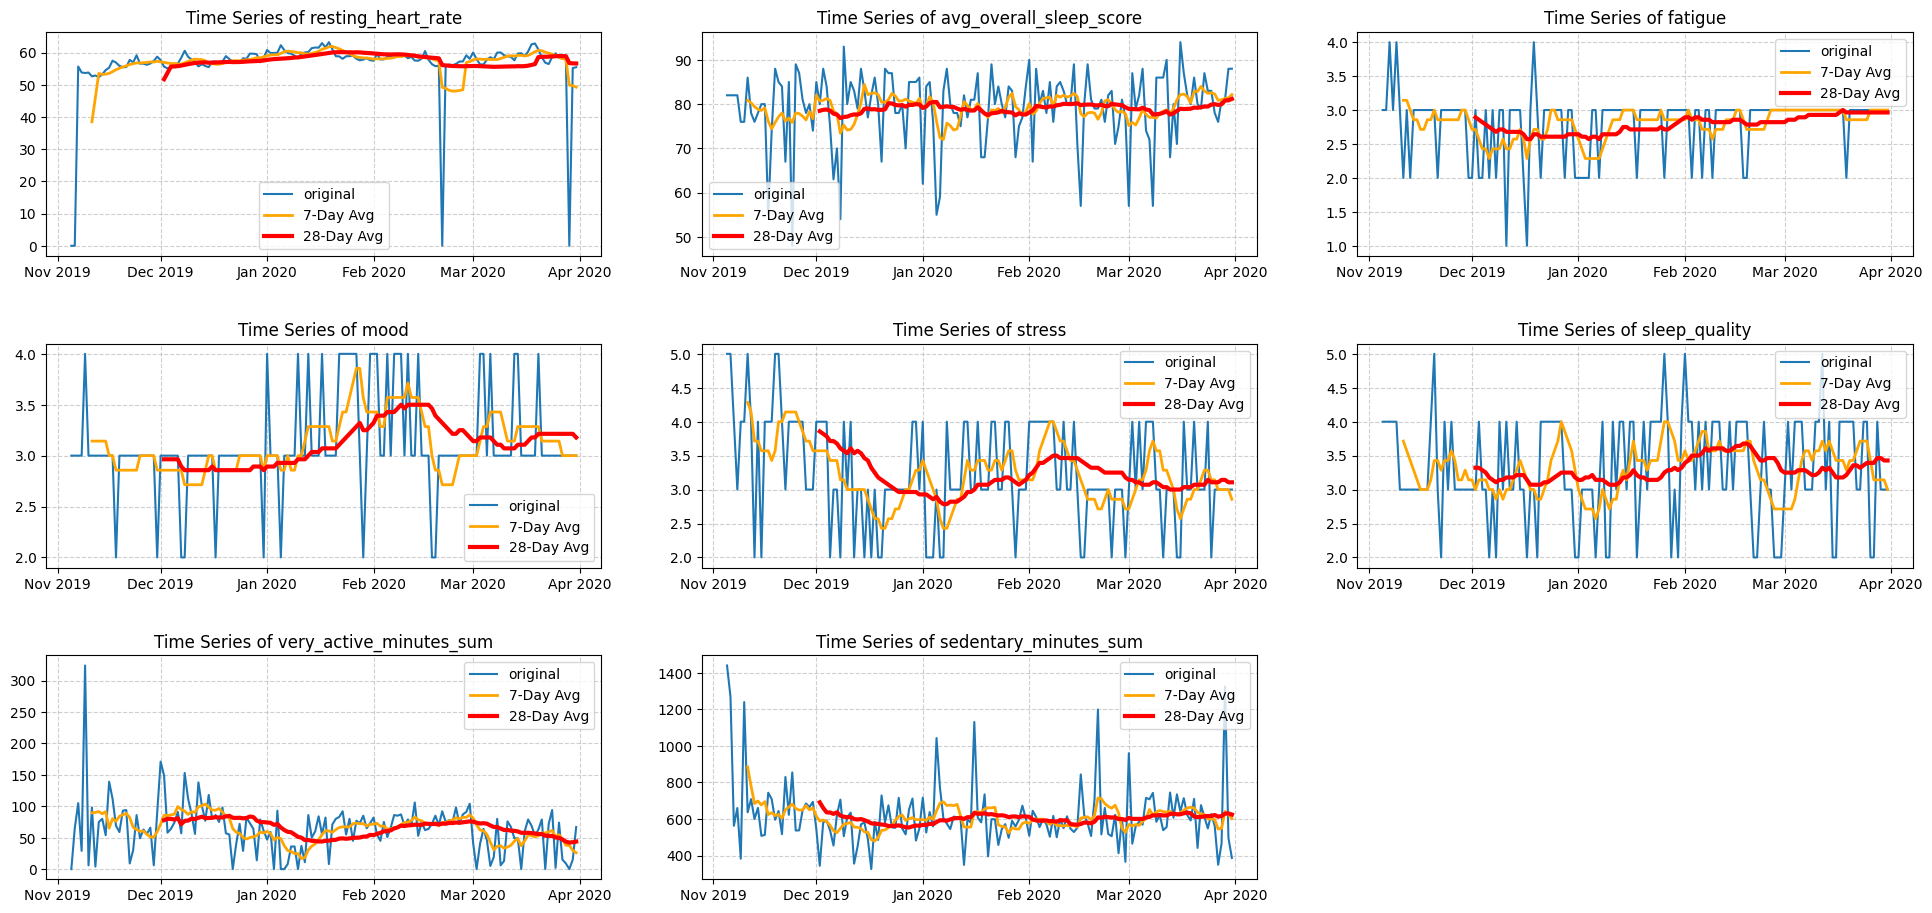

In [21]:
draw_plots_grid(df, df.columns, nrows = 5, ncols = 3)

In [22]:
df.shape

(148, 8)

Calculate Rolling Baselines: For each student, we need to calculate their personal 30-day rolling baseline (mean and standard deviation) for the physiological metrics.

Calculate rhr_30d_mean and rhr_30d_std for resting_heart_rate.
Calculate sleep_score_30d_mean and sleep_score_30d_std for avg_overall_sleep_score.
Calculate Daily Sub-Scores: Using the baselines, we'll compute the two components of the risk score for each day.

Subjective_Distress_Score (0-4 points): Sum points for negative self-reports (fatigue, mood, stress, sleep_quality scores of 1 or 2).
Physiological_Deviation_Score (0-2 points):
+1 point if resting_heart_rate is more than one standard deviation above its 30-day mean.
+1 point if avg_overall_sleep_score is more than one standard deviation below its 30-day mean.
Calculate Composite Risk Score:

Create a Composite_Risk_Score column by summing the two scores above.
Identify High-Risk State:

Create a binary High_Risk_State column, flagging any day where Composite_Risk_Score >= 3 as 1 and all others as 0.
Engineer the Final Target (Is_High_Risk_Next_7_Days):

This is the final step. For each day, we will look forward into the next 7 days. If a High_Risk_State (1) occurs at any point within that window, we will set Is_High_Risk_Next_7_Days to 1 for the current day. Otherwise, it will be 0.

In [57]:
def calculate_rolling_baselines(df, columns, window_size, calculate_mean, calculate_std):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    for column in columns:
        if column in df.columns:
            if calculate_mean:
                column_name = f"{column}_{window_size}_mean"
                df[column_name] = df[column].rolling(window_size).mean()
                df[column_name] = df[column_name].bfill()
                
            if calculate_std:
                column_name = f"{column}_{window_size}_std"
                df[column_name] = df[column].rolling(window_size).std()
                df[column_name] = df[column_name].bfill()
            
        

    return df


In [58]:
df = calculate_rolling_baselines(df, ["resting_heart_rate","avg_overall_sleep_score"], window_size=14, calculate_mean=True, calculate_std=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 2019-11-05 to 2020-03-31
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   resting_heart_rate               148 non-null    float64
 1   avg_overall_sleep_score          148 non-null    float64
 2   fatigue                          148 non-null    float64
 3   mood                             148 non-null    float64
 4   stress                           148 non-null    float64
 5   sleep_quality                    148 non-null    float64
 6   very_active_minutes_sum          148 non-null    int64  
 7   sedentary_minutes_sum            148 non-null    int64  
 8   resting_heart_rate_14_mean       148 non-null    float64
 9   resting_heart_rate_14_std        148 non-null    float64
 10  avg_overall_sleep_score_14_mean  148 non-null    float64
 11  avg_overall_sleep_score_14_std   148 non-null    float64
dtypes: 

In [100]:
def calculate_subjective_score(df: pd.DataFrame, subjective_cols: list) -> pd.Series:
    """
    Calculates the subjective distress score based on a list of columns.

    Args:
        df: The input DataFrame.
        subjective_cols: A list of column names to evaluate. The rule is
                         that a score <= 2 for any of these columns adds
                         1 point to the daily score.

    Returns:
        A pandas Series containing the calculated Subjective_Distress_Score
        for each day.
    """
    # Initialize a Series of zeros to hold the score
    total_score = pd.Series(0, index=df.index)
    
    for col in subjective_cols:
        # For each column, create the boolean mask, convert to int (0 or 1),
        # and add it to the total score.
        total_score += (df[col] <= 2).astype(int)
        
    return total_score


def calculate_physiological_score(df: pd.DataFrame, deviation_configs: list) -> pd.Series:
    """
    Calculates the physiological deviation score based on a list of
    configuration dictionaries.

    Args:
        df: The input DataFrame.
        deviation_configs: A list of dictionaries. Each dictionary must contain:
                           'metric': the column to check (e.g., 'resting_heart_rate')
                           'mean': the baseline mean column
                           'std': the baseline std dev column
                           'direction': 'above' or 'below' for the deviation

    Returns:
        A pandas Series containing the calculated Physiological_Deviation_Score
        for each day.
    """
    total_score = pd.Series(0, index=df.index)

    # Iterate through the configuration list
    for config in deviation_configs:
        metric_col = config['metric']
        mean_col = config['mean']
        std_col = config['std']
        direction = config['direction']
        
        # Dynamically apply the logic based on the 'direction'
        if direction == 'above':
            points = (df[metric_col] > (df[mean_col] + df[std_col])).astype(int)
        elif direction == 'below':
            points = (df[metric_col] < (df[mean_col] - df[std_col])).astype(int)
        else:
            # If config is invalid, return no points for that rule
            points = 0
            
        total_score += points
        
    return total_score

def add_risk_scores(df_with_baselines: pd.DataFrame, subjective_cols_config: list, physiological_cols_config: list) -> pd.DataFrame:
    """
    Main wrapper function to calculate and append all daily risk sub-scores.

    Args:
        df_with_baselines: DataFrame with all features and baseline columns.
        subjective_cols_config: List of columns for the subjective score.
        physiological_cols_config: List of config dicts for the physiological score.

    Returns:
        A new DataFrame with the two score columns appended.
    """
    df_out = df_with_baselines.copy()

    df_out['Subjective_Distress_Score'] = calculate_subjective_score(
        df=df_out,
        subjective_cols=subjective_cols_config
    )
    
    df_out['Physiological_Deviation_Score'] = calculate_physiological_score(
        df=df_out,
        deviation_configs=physiological_cols_config
    )
    
    print("Successfully calculated and appended daily risk scores using refactored functions.")
    return df_out



In [105]:
df.columns

Index(['resting_heart_rate', 'avg_overall_sleep_score', 'fatigue', 'mood',
       'stress', 'sleep_quality', 'very_active_minutes_sum',
       'sedentary_minutes_sum', 'resting_heart_rate_14_mean',
       'resting_heart_rate_14_std', 'avg_overall_sleep_score_14_mean',
       'avg_overall_sleep_score_14_std'],
      dtype='object')

In [106]:
SUBJECTIVE_COLS = ['fatigue', 'mood', 'stress', 'sleep_quality']

PHYSIOLOGICAL_CONFIG = [
    {
        'metric': 'resting_heart_rate',
        'mean': 'resting_heart_rate_14_mean',
        'std': 'resting_heart_rate_14_std',
        'direction': 'above'
    },
    {
        'metric': 'avg_overall_sleep_score',
        'mean': 'avg_overall_sleep_score_14_mean',
        'std': 'avg_overall_sleep_score_14_std',
        'direction': 'below'
    }
]

In [108]:
df = add_risk_scores(df, 
                subjective_cols_config = SUBJECTIVE_COLS,
                physiological_cols_config=PHYSIOLOGICAL_CONFIG)

Successfully calculated and appended daily risk scores using refactored functions.


In [111]:
df.sample(10)

,resting_heart_rate,avg_overall_sleep_score,fatigue,mood,stress,sleep_quality,very_active_minutes_sum,sedentary_minutes_sum,resting_heart_rate_14_mean,resting_heart_rate_14_std,avg_overall_sleep_score_14_mean,avg_overall_sleep_score_14_std,Subjective_Distress_Score,Physiological_Deviation_Score
dateTime,,,,,,,,,,,,,,
2020-02-10,59.072969,85.0,3.0,3.0,3.0,4.0,69,600,58.489489,0.819076,80.000000,6.917091,0,0
2020-02-04,57.870998,80.0,3.0,3.0,4.0,3.0,75,556,58.262319,0.653296,79.785714,6.658466,0,0
2020-03-29,0.000000,81.0,3.0,3.0,3.0,3.0,0,1325,55.000750,15.943748,82.642857,4.617811,0,0
2020-01-13,60.161987,82.0,3.0,4.0,4.0,4.0,86,349,59.890564,1.015612,76.500000,10.456871,0,0
2020-02-28,59.130889,81.0,3.0,3.0,3.0,2.0,91,604,53.041844,15.327676,77.500000,7.562560,1,0
2020-01-02,59.830235,84.0,2.0,3.0,2.0,3.0,59,526,58.496142,1.252210,80.142857,8.272821,2,1
2020-03-07,57.916686,72.0,3.0,3.0,4.0,3.0,19,708,57.516048,1.196579,77.428571,7.841843,0,0
2019-12-25,58.230284,78.0,3.0,3.0,3.0,4.0,29,716,56.990901,0.969737,81.642857,5.772710,0,1
2020-02-19,55.758712,81.0,2.0,2.0,3.0,4.0,85,507,58.319960,1.285008,79.857143,8.169899,2,0
